In [63]:
import torch
import cv2 as cv
import json
import numpy as np
import matplotlib.pyplot as plt
import os

from dataset.dataset import ImageDataset
from modules.split_modules import SplitModel

In [4]:
# load model
MODEL_WEIGHT = '/Users/longhoang/Developer/table-reg/pretrain-models/split-merge/split_v2.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = SplitModel(3)
net = torch.nn.DataParallel(net).to(device)

if device == 'cuda':
    net.load_state_dict(torch.load(MODEL_WEIGHT))
else:
    net.load_state_dict(torch.load(MODEL_WEIGHT, map_location=torch.device('cpu')))

device

'cpu'

In [7]:
# load validation dataset
IMG_DIR = '/Users/longhoang/Developer/table-reg/data/scitsr-split-train/val/img'
LABEL = '/Users/longhoang/Developer/table-reg/data/scitsr-split-train/val/label/split-label.json'

with open(LABEL, 'r') as f:
    labels = json.load(f)
    
dataset = ImageDataset(IMG_DIR, labels, 8, scale=1)

In [42]:
IDX = 10 # id of sample example

img, label = dataset[IDX]
net.eval()
r,c = net(img.unsqueeze(0))

# format predictions
r = r[-1]>0.5
c = c[-1]>0.5
c = c.cpu().detach().numpy()
r = r.cpu().detach().numpy()
r_im = r.reshape((-1,1)) * np.ones((r.shape[0],c.shape[0]))
c_im = c.reshape((1,-1)) * np.ones((r.shape[0],c.shape[0]))
im = cv.bitwise_or(r_im,c_im)

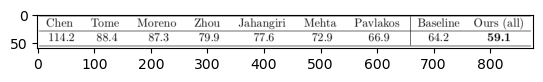

In [43]:
img_np = (img * 255).numpy().transpose(1,2,0).astype(np.uint8)
plt.imshow(img_np)

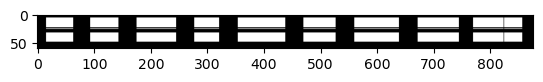

In [44]:
mask = (im * 255).astype(np.uint8)
mask_inv = cv.bitwise_not(mask)
plt.imshow(mask_inv, cmap='gray')

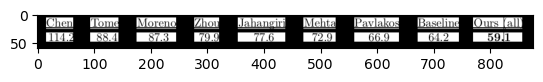

In [45]:
res = cv.bitwise_and(img_np, img_np, mask=mask_inv)
plt.imshow(res)

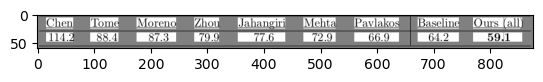

In [46]:
res2 = cv.addWeighted(img_np, 0.5, res, 0.5, 0)
plt.imshow(res2)

In [66]:
def visualize_split(model, dataset, id, save_dir=None):
    model.eval()
    img, label = dataset[id]
    r, c = model(img.unsqueeze(0))
    
    # format predictions
    r = r[-1]>0.5
    c = c[-1]>0.5
    c = c.cpu().detach().numpy()
    r = r.cpu().detach().numpy()
    r_im = r.reshape((-1,1)) * np.ones((r.shape[0],c.shape[0]))
    c_im = c.reshape((1,-1)) * np.ones((r.shape[0],c.shape[0]))
    mask = cv.bitwise_or(r_im,c_im)

    img_np = (img * 255).numpy().transpose(1,2,0).astype(np.uint8)
    mask = (mask * 255).astype(np.uint8)
    mask_inv = cv.bitwise_not(mask)

    res = cv.bitwise_and(img_np, img_np, mask=mask_inv)
    res2 = cv.addWeighted(img_np, 0.5, res, 0.5, 0)
    if save_dir:
        save_path = os.path.join(save_dir, f'split_pred_{id}.png')
        cv.imwrite(save_path, cv.cvtColor(res2, cv.COLOR_RGB2BGR))
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(res2)

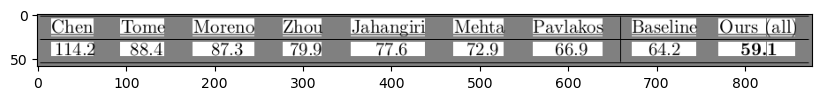

In [67]:
visualize_split(net, dataset, IDX)

In [68]:
visualize_split(net, dataset, IDX, '/Users/longhoang/Developer/table-reg/imgs')